In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplt
import descartes
import geopandas as gpd
import numpy as np
import datetime

from shapely.geometry import Point, Polygon
%matplotlib inline

# CS 418 Semester Project, Analysis of Fire Start Data across United States

### Group Members:
* Trevor Parchem (tparch3)
* Sai Nadkarni (snadka2)

### Inspections

To-Do list WIP

Unpreventable fires:-
1. Lightning fires all years
2. Lightning fires over the last decade
3. Deliberate fires as part of prescribed burn

Preventable fires:-
1. Campfires
2. Smoking
3. Juveniles
4. Incendiary

Detailed analyses- Get co-ords of localities with high population, cross check with obtained points to see interlap. Encourage preventative steps in those locations

Ambitious goal- Use linear regression to plot trend for lightning fires(possible to predict nature? unsure)

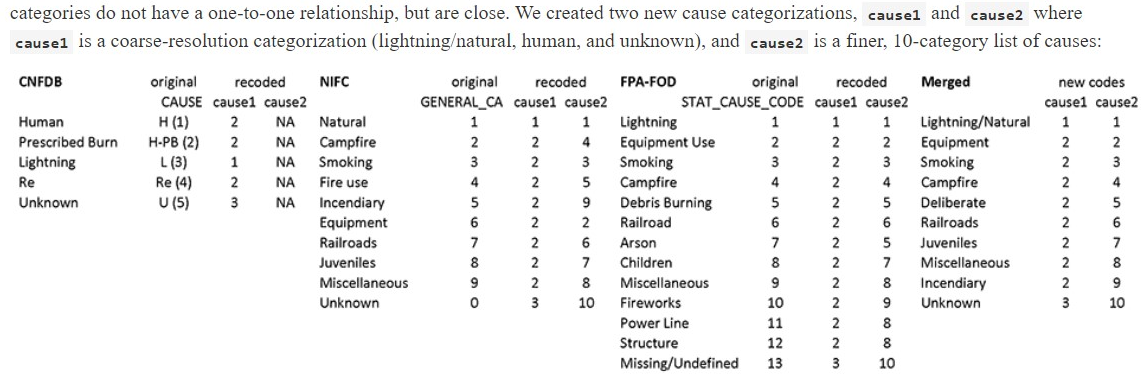

## Loading the Data

In [3]:
# Load the data from the CSV file containing the merged records from United States & Canada Fire Agencies
data = pd.read_csv("uscan_1986-2013.csv")

data.head(10)

,datasource,sourceid,latitude,longitude,year,mon,day,daynum,area_ha,cause_original,cause1,cause2,stateprov,agency
0,fpafod,1,40.036944,-121.005833,2005,2,2,33,0.040469,9,2,8,CA,FS
1,fpafod,2,38.933056,-120.404444,2004,5,12,133,0.101171,1,1,1,CA,FS
2,fpafod,3,38.984167,-120.735556,2004,5,31,152,0.040469,5,2,5,CA,FS
3,fpafod,4,38.559167,-119.913333,2004,6,28,180,0.040469,1,1,1,CA,FS
4,fpafod,5,38.559167,-119.933056,2004,6,28,180,0.040469,1,1,1,CA,FS
5,fpafod,6,38.635278,-120.103611,2004,6,30,182,0.040469,1,1,1,CA,FS
6,fpafod,7,38.688333,-120.153333,2004,7,1,183,0.040469,1,1,1,CA,FS
7,fpafod,8,40.968056,-122.433889,2005,3,8,67,0.323749,5,2,5,CA,FS
8,fpafod,9,41.233611,-122.283333,2005,3,15,74,0.404686,5,2,5,CA,FS
9,fpafod,10,38.548333,-120.149167,2004,7,1,183,0.040469,1,1,1,CA,FS


In [4]:
#Remove unneeded columns
data = data.drop(columns=['sourceid', 'agency', 'datasource'])

In [5]:
#Filter to only US locations
stateList = ['CA', 'NM', 'OR', 'NC', 'WY', 'CO', 'WA', 'MT', 'UT', 'AZ', 'SD',
       'AR', 'NV', 'ID', 'MN', 'TX', 'FL', 'SC', 'LA', 'OK', 'KS', 'MO',
       'NE', 'MI', 'KY', 'OH', 'IN', 'VA', 'IL', 'TN', 'GA', 'AK', 'ND',
       'WV', 'WI', 'AL', 'NH', 'PA', 'MS', 'ME', 'VT', 'NY', 'IA', 'DC',
       'MD', 'CT', 'MA', 'NJ', 'HI', 'DE', 'PR', 'RI']

usData = data[data['stateprov'].isin(stateList)]

### Filter out small fires

An elementary step we will take here is to filter out fire sizes lesser than 20sq meters.

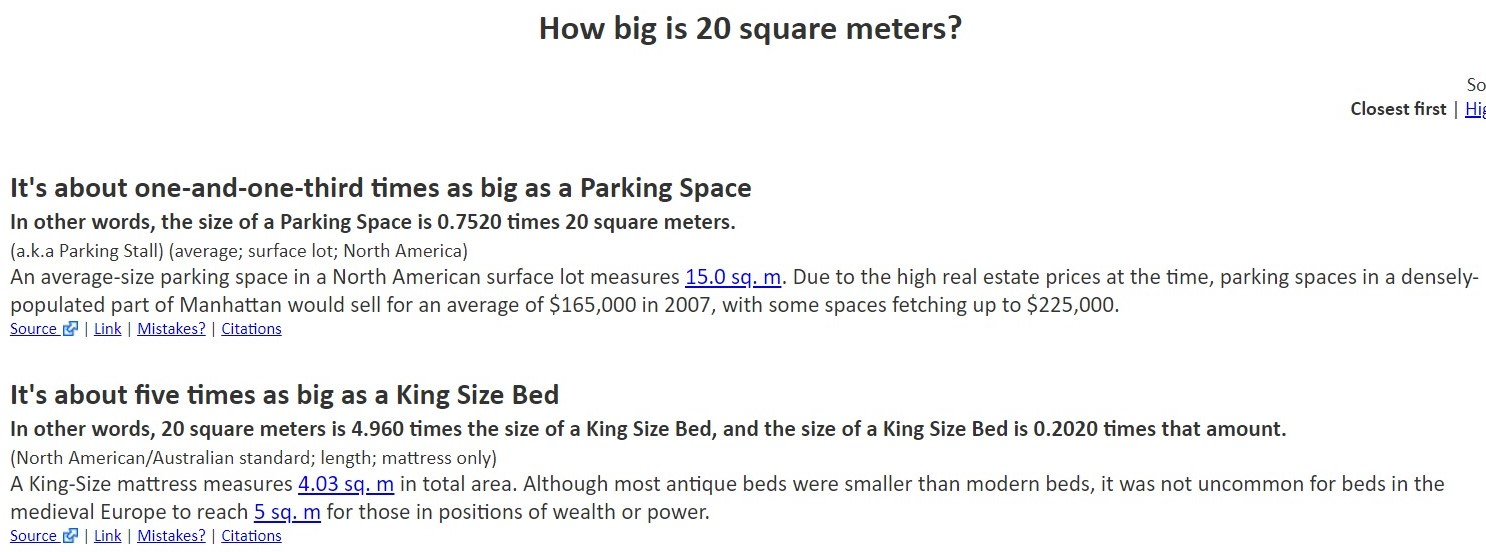

In [6]:
usData = usData[usData['area_ha'] > 0.002]
print(usData['year'].describe())

count    1.840184e+06
mean     2.001918e+03
std      6.877836e+00
min      1.986000e+03
25%      1.996000e+03
50%      2.002000e+03
75%      2.008000e+03
max      2.013000e+03
Name: year, dtype: float64


In [7]:
usData.head(10)

,latitude,longitude,year,mon,day,daynum,area_ha,cause_original,cause1,cause2,stateprov
0,40.036944,-121.005833,2005,2,2,33,0.040469,9,2,8,CA
1,38.933056,-120.404444,2004,5,12,133,0.101171,1,1,1,CA
2,38.984167,-120.735556,2004,5,31,152,0.040469,5,2,5,CA
3,38.559167,-119.913333,2004,6,28,180,0.040469,1,1,1,CA
4,38.559167,-119.933056,2004,6,28,180,0.040469,1,1,1,CA
5,38.635278,-120.103611,2004,6,30,182,0.040469,1,1,1,CA
6,38.688333,-120.153333,2004,7,1,183,0.040469,1,1,1,CA
7,40.968056,-122.433889,2005,3,8,67,0.323749,5,2,5,CA
8,41.233611,-122.283333,2005,3,15,74,0.404686,5,2,5,CA
9,38.548333,-120.149167,2004,7,1,183,0.040469,1,1,1,CA


In [16]:
def geography(dataset):
    
    #Create points from lat and long
    geometry = [Point(xy) for xy in zip(dataset['longitude'], dataset['latitude'])]
    
    #Specify Co-ordinate reference system, Create geodataframe
    crs = { 'init': 'epsg:4326' }
    geoData = gpd.GeoDataFrame(dataset, crs = crs, geometry = geometry)
    return geoData

In [19]:
geoUSData = geography(usData)

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


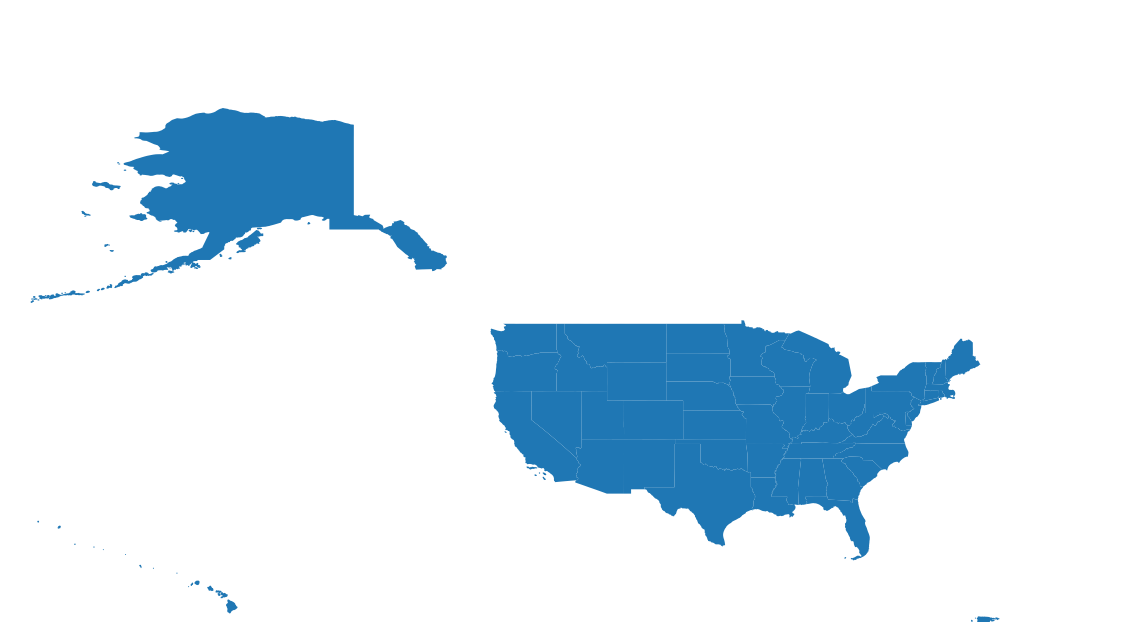

In [10]:
usMap = gpd.read_file("tl_2017_us_state.shp")
fig, ax = pyplt.subplots(figsize = (20, 20))
usMap.plot(ax = ax);
xlim = ([-182, -50])
ylim = ([18, 82])
ax.set_xlim(xlim);
ax.set_ylim(ylim);
ax.set_axis_off();

In [ ]:
fig, ax = pyplt.subplots(figsize = (20, 20))
usMap.plot(ax = ax);
xlim = ([-182, -50])
ylim = ([18, 82])
ax.set_xlim(xlim);
ax.set_ylim(ylim);
ax.set_axis_off();

geoUSData.plot(ax = ax, markersize = 1, color = "red", marker = "o");

<AxesSubplot:>

(-182.0, -50.0)

(18.0, 82.0)

### Takeaways

This is a huge amount of data to go through, and harder for us to pinpoint specific instances of fires we want to highlight. Hence, we will drill down to fires within the states of California, Oregon and Washington; the west coast.

## West coast analysis

In [18]:
# Filter data down to only West Coast wildfires
westCoastData = usData[usData['stateprov'].isin(['CA', 'WA', 'OR'])]
print(westCoastData['year'].describe())

count    296770.000000
mean       2000.407069
std           7.520974
min        1986.000000
25%        1994.000000
50%        2001.000000
75%        2007.000000
max        2013.000000
Name: year, dtype: float64


In [21]:
geoWCData = geography(westCoastData)

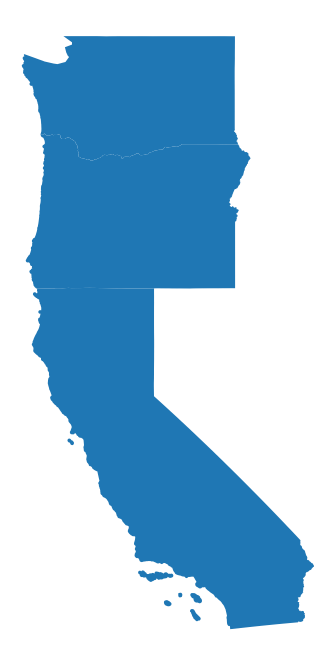

In [22]:
fig, ax = pyplt.subplots(figsize = (12, 12))
westCoastMap = usMap[usMap['NAME'].isin(['California', 'Oregon', 'Washington'])]
westCoastMap.plot(ax = ax);
ax.set_axis_off();

In [36]:
# caMap = usMap[usMap['NAME'] == 'California'].plot(figsize=(12,12))
# xlim = ([-182, -50])
# ylim = ([18, 82])
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_axis_off()

In [55]:
# fig, ax = pyplt.subplots(figsize = (12, 12))
# caMap.plot(ax = ax)

# geoCAData.plot(ax = ax, markersize = 1, color = "red", marker = "o")

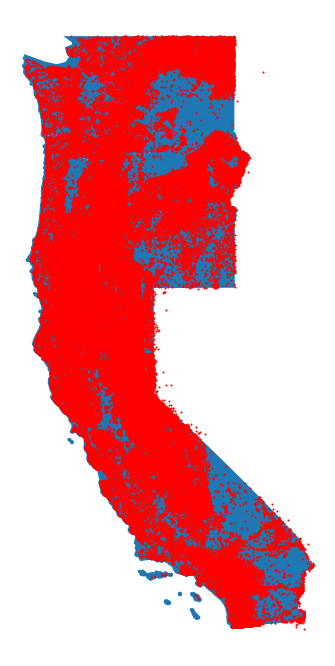

In [23]:
fig, ax = pyplt.subplots(figsize = (12, 12))
westCoastMap.plot(ax = ax);
geoWCData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

### Lightning started fires 1986-2013

C:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


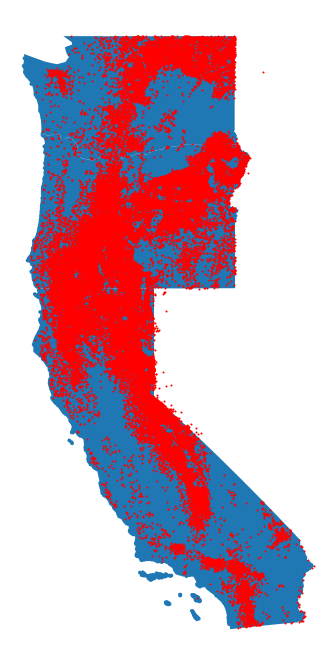

In [24]:
#Lightning started fires
lightningData = westCoastData[westCoastData['cause1'] == 1]
geoLightningData = geography(lightningData)
fig, ax = pyplt.subplots(figsize = (12, 12))
westCoastMap.plot(ax = ax);
geoLightningData.plot(ax = ax, markersize = 1, color = "red", marker = "o");
ax.set_axis_off();

In [47]:
len(westCoastData['area_ha'])

299428